In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np
from sklearn.datasets import load_files

In [ ]:
d_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(d_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
features = layers.Flatten()(x)
x = layers.Dropout(0.4)(features)
x = layers.Dense(1, activation="sigmoid")(x)

discriminator = Model(d_input, x, name='discriminator')
feature_model = Model(d_input, features, name='feature_model')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)       

In [ ]:
generator = tf.keras.Sequential(
    [
        layers.Input(shape=(100,)),
        layers.Dense(256*4*4),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name='generator'
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0 

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # print(real_images.shape)
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        # labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        self.discriminator.trainable=False
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.discriminator.trainable=True
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=100)

In [ ]:
gc.collect()

735

In [ ]:
gc.collect()

0

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-5Y_bbsUogkAlEz3f-4CflbT40jg-UFJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-5Y_bbsUogkAlEz3f-4CflbT40jg-UFJ" -O 10_painting.zip && rm -rf /tmp/cookies.txt

--2023-06-27 06:56:12--  https://docs.google.com/uc?export=download&confirm=t&id=1-5Y_bbsUogkAlEz3f-4CflbT40jg-UFJ
Resolving docs.google.com (docs.google.com)... 74.125.68.101, 74.125.68.100, 74.125.68.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.68.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/474lpc0ji98m9vh2f699hnmgfk11lkv6/1687848900000/14533323077134147075/*/1-5Y_bbsUogkAlEz3f-4CflbT40jg-UFJ?e=download&uuid=8b497458-331d-4d8e-be7d-edcccd05830b [following]
--2023-06-27 06:56:12--  https://doc-00-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/474lpc0ji98m9vh2f699hnmgfk11lkv6/1687848900000/14533323077134147075/*/1-5Y_bbsUogkAlEz3f-4CflbT40jg-UFJ?e=download&uuid=8b497458-331d-4d8e-be7d-edcccd05830b
Resolving doc-00-3c-docs.googleusercontent.com (doc-00-3c-docs.googleusercontent.com)... 142.251.12.132, 2404

In [ ]:
!unzip -q 10_painting.zip

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ICRO0C8XY9LYR5UPxbHowV1Yxfybkh0D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ICRO0C8XY9LYR5UPxbHowV1Yxfybkh0D" -O 10_real.zip && rm -rf /tmp/cookies.txt

--2023-06-27 06:57:02--  https://docs.google.com/uc?export=download&confirm=t&id=1ICRO0C8XY9LYR5UPxbHowV1Yxfybkh0D
Resolving docs.google.com (docs.google.com)... 74.125.68.138, 74.125.68.100, 74.125.68.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.68.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aok8mjjg34diu619jnk6crqmr3k3ienq/1687848975000/14533323077134147075/*/1ICRO0C8XY9LYR5UPxbHowV1Yxfybkh0D?e=download&uuid=c2da1e68-707a-41b8-a8cf-cbb7c1d6235d [following]
--2023-06-27 06:57:03--  https://doc-0c-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aok8mjjg34diu619jnk6crqmr3k3ienq/1687848975000/14533323077134147075/*/1ICRO0C8XY9LYR5UPxbHowV1Yxfybkh0D?e=download&uuid=c2da1e68-707a-41b8-a8cf-cbb7c1d6235d
Resolving doc-0c-3c-docs.googleusercontent.com (doc-0c-3c-docs.googleusercontent.com)... 142.251.12.132, 2404

In [ ]:
!unzip -q 10_real.zip

In [ ]:
real_images = tf.keras.utils.image_dataset_from_directory(
    directory='real/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=((32, 32)),
)

painting_images = tf.keras.utils.image_dataset_from_directory(
    directory='painting/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=((32, 32)),
)

Found 4653 files belonging to 10 classes.
Found 2287 files belonging to 10 classes.


In [ ]:
x_real, y_real = np.concatenate(list(real_images.map(lambda x, y: x))), np.concatenate(list(real_images.map(lambda x, y: y)))
x_paint, y_paint = np.concatenate(list(painting_images.map(lambda x, y: x))), np.concatenate(list(painting_images.map(lambda x, y: y)))

In [ ]:
x_real = (x_real-127.5)/127.5

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
x_real_ = x_real.copy()
y_real_ = y_real.copy()

for i in range(19):
    aug_ds = data_augmentation(x_real).numpy()
    x_real_ = np.concatenate([x_real_, aug_ds])
    y_real_ = np.concatenate([y_real_, y_real])

In [ ]:
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

h = gan.fit(
    x_real_,
    epochs=20,
    batch_size=128,
    shuffle=True,
)

Epoch 1/20
728/728 [==============================] - 62s 67ms/step - d_loss: 0.5108 - g_loss: 1.5520
Epoch 2/20
728/728 [==============================] - 48s 65ms/step - d_loss: 0.5903 - g_loss: 1.1969
Epoch 3/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5955 - g_loss: 1.1089
Epoch 4/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5862 - g_loss: 1.0755
Epoch 5/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5814 - g_loss: 1.0757
Epoch 6/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5479 - g_loss: 1.1944
Epoch 7/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5632 - g_loss: 1.1008
Epoch 8/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5532 - g_loss: 1.1458
Epoch 9/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5509 - g_loss: 1.1300
Epoch 10/20
728/728 [==============================] - 48s 66ms/step - d_loss: 0.5

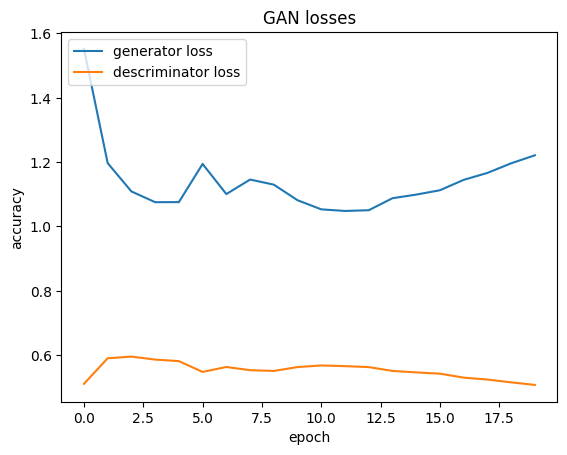

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['g_loss'])
plt.plot(h.history['d_loss'])
plt.title('GAN losses')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['generator loss', 'descriminator loss'], loc='upper left')
plt.show()

In [ ]:
test = tf.random.normal(shape=(10, 100))

In [ ]:
fake = gan.generator(test)
fake = (fake+1)/2.0

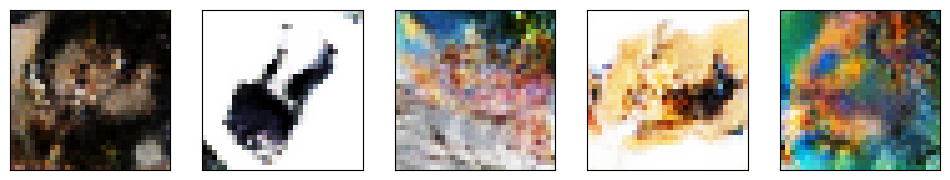

In [ ]:
def display(x1):
    n = 5  # How many digits we will display
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x1[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

display(fake)

In [ ]:
x_paint = (x_paint-127.5)/127.5

In [ ]:
def onehot_to_label(x):
    labels = []
    for i in range(x.shape[0]):
        labels.append(np.argmax(x[i]))
    return labels

In [ ]:
features_train = feature_model(x_real)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=10, random_state=0, warm_start=True, n_estimators=1)
clf.fit(features_train, onehot_to_label(y_real))
clf.n_estimators+=1

In [ ]:
features_test = feature_model(x_paint)

In [ ]:
y_pred = clf.predict(features_test)

In [ ]:
accuracy_score(onehot_to_label(y_paint), y_pred)

0.08526453869698294

In [ ]:
from sklearn.model_selection import train_test_split
x_paint_train, x_paint_test, y_paint_train, y_paint_test = train_test_split(x_paint, y_paint, test_size=0.2, random_state=42)

In [ ]:
features_paint_train = feature_model(x_paint_train)

In [ ]:
clf.fit(features_paint_train, onehot_to_label(y_paint_train))

RandomForestClassifier(max_depth=10, n_estimators=2, random_state=0,
                       warm_start=True)

In [ ]:
features_paint_test = feature_model(x_paint_test)

In [ ]:
y_pred = clf.predict(features_paint_test)

In [ ]:
accuracy_score(onehot_to_label(y_paint_test), y_pred)

0.14192139737991266